In [ ]:
# 2-1. 들어가며

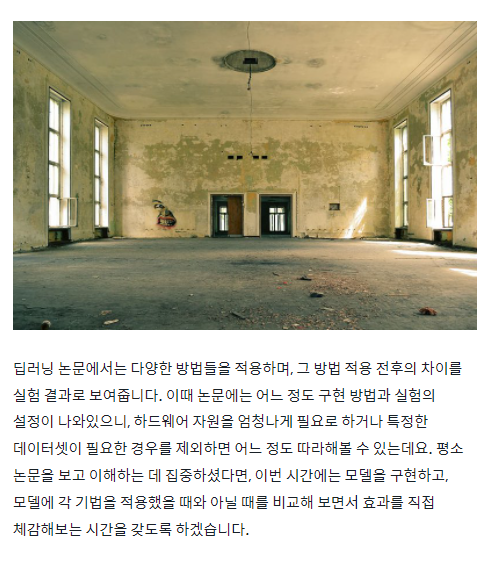

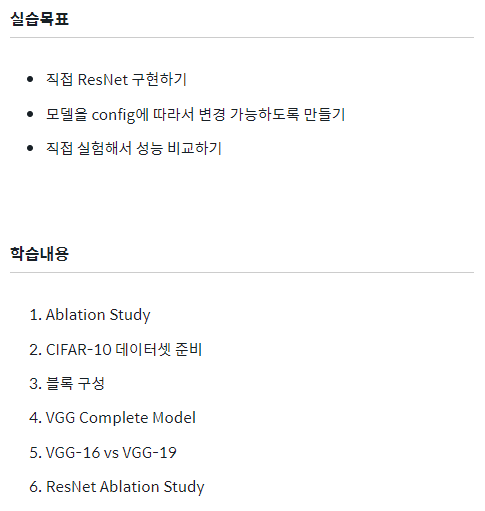

In [ ]:
# 2-2. Ablation Study

https://www.quora.com/In-the-context-of-deep-learning-what-is-an-ablation-study

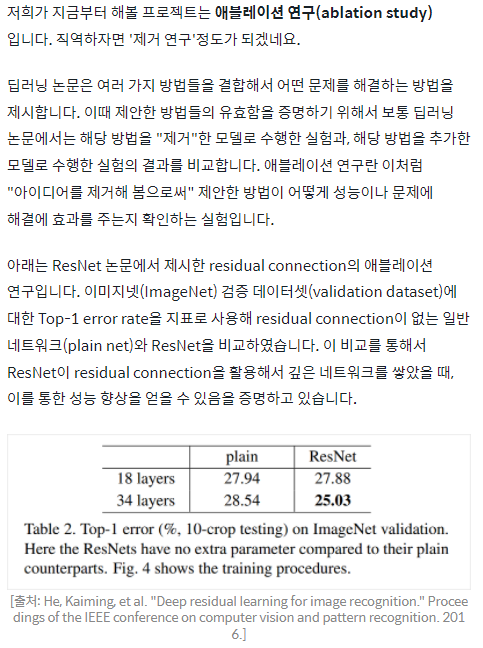

In [ ]:
# 2-3. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

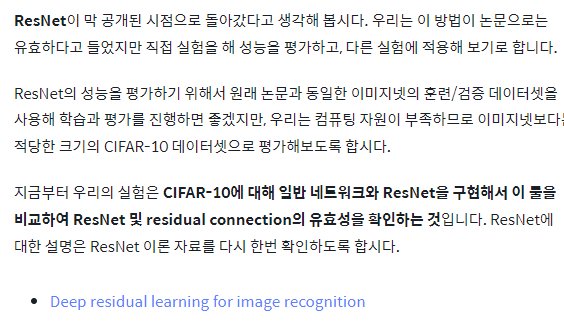

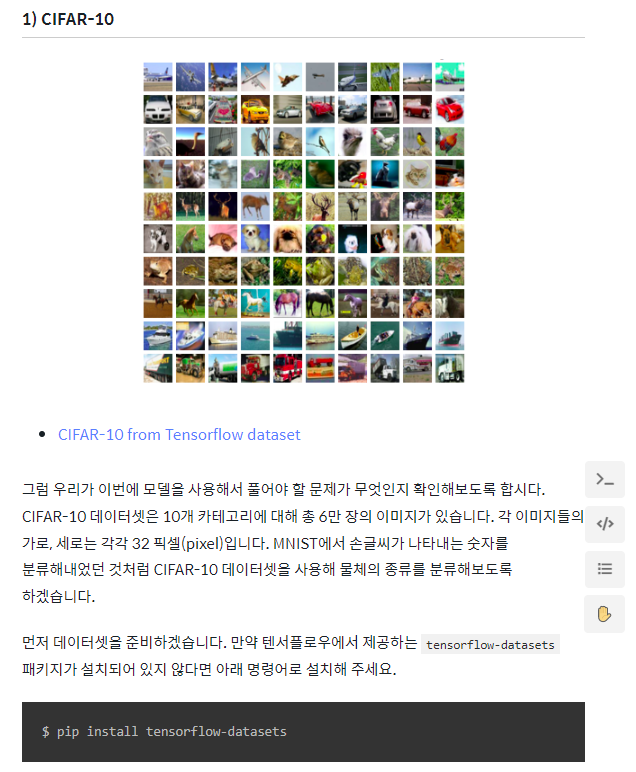

https://www.tensorflow.org/datasets/catalog/cifar10

In [ ]:
!pip install tensorflow-datasets

In [ ]:
# Tensorflow and tf.keras

import tensorflow as tf
from tensorflow import keras

# Helper libararies

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 보자!

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

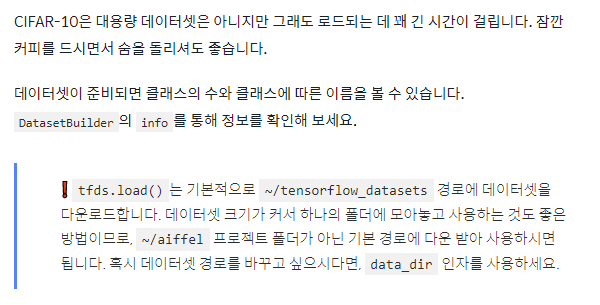

In [ ]:
!pip install urllib3
import urllib3
urllib3.disable_warnings()

# tfds.disable_progress_bar() # 이 주석을 풀면 데이터셋 다운로드 과정의 progress바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해보자  cardinality : 집합의 크기를 의미한다.

print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


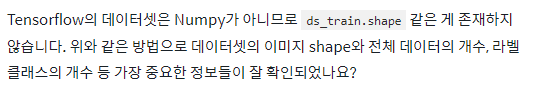

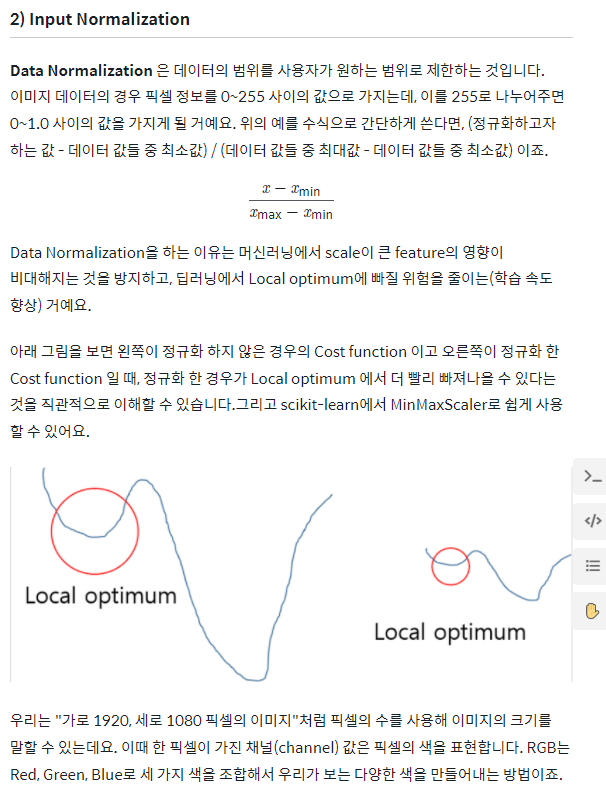

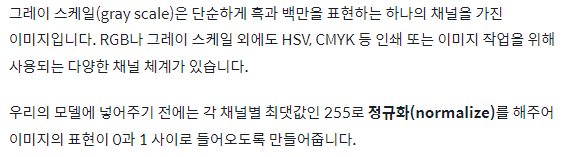

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=1
  )
  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

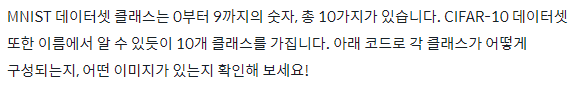

In [ ]:
ds_info.features['label'].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

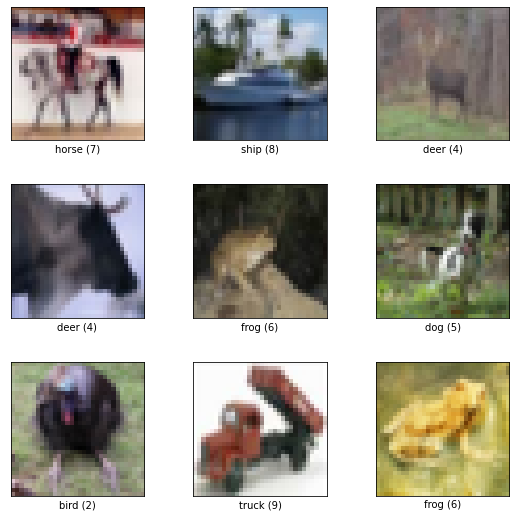

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

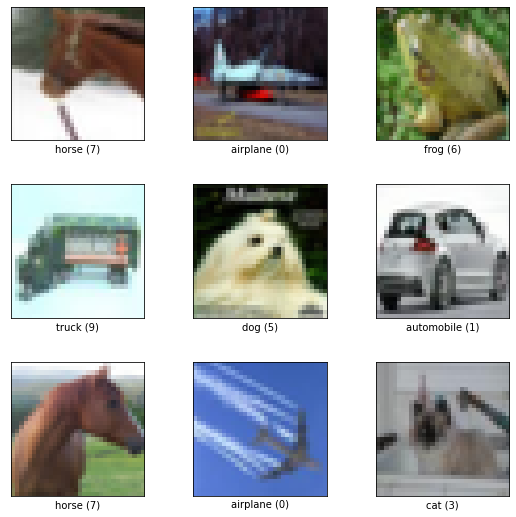

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

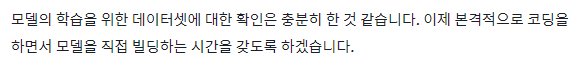

In [ ]:
# 2-4. Ablation Study 실습 (2) 블록 구성하기

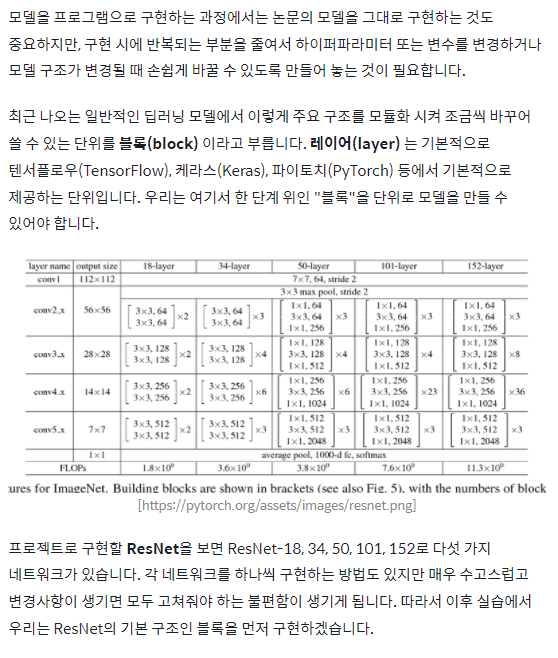

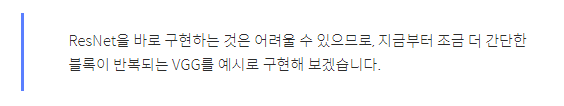

딥러닝 교과서 : p.267 vgg 넷 내용 나온다.

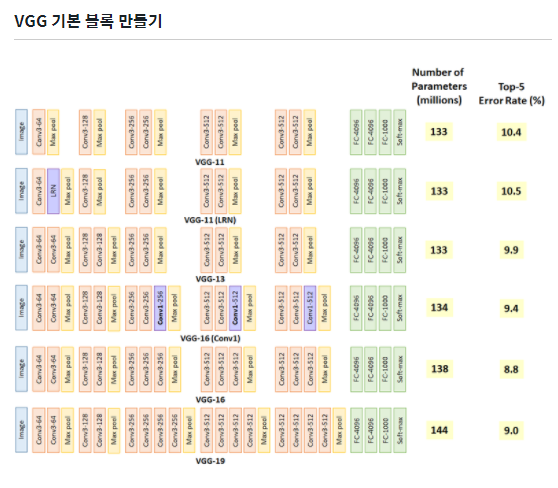

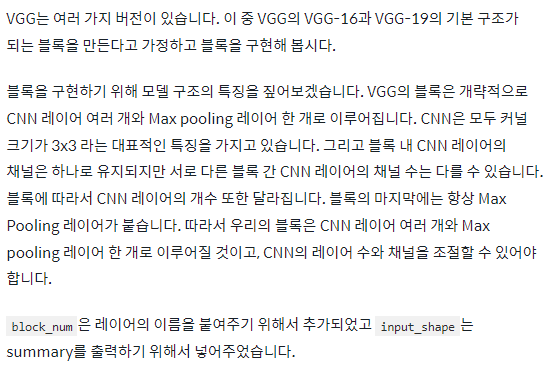

In [ ]:
# function for building VGG block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,                    
                    ):
    # 입력 레이어
    x = input_layer

    # cnn 레이어
    for cnn_num in range(num_cnn):
      x = keras.layers.Conv2D(
          filters=channel,
          kernel_size=(3, 3),
          activation='relu',
          kernel_initializer = 'he_normal',
          padding='same',
          name=f'block{block_num}_conv{cnn_num}'
      )(x)

    # max pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3)) # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_______________________________________________________

In [ ]:
# 2-5. Ablation Study 실습 (3) VGG Complete Model

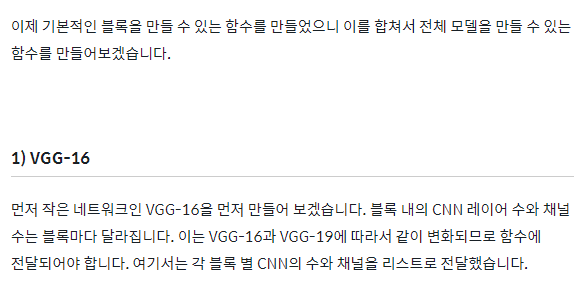

vggnet은 11계층부터 13계층, 16계층, 19계층까지 총 6가지 종류의 모델로 구성된다.

그중 16계층 모델이 가장 많이 쓰이며 짧게 'VGG16'이라고 부른다. 19 계층 모델인 'VGG 19'의 경우 
VGG16'보다 파라미터 수는 많지만 성능차가 크지 않아 많이 쓰이지 않는다.

In [ ]:
# VGG 모델 자체를 생성하는 함수이다.

def build_vgg(input_shape=(32, 32, 3),
              num_cnn_list=[2, 2, 3, 3, 3],
              channel_list=[64, 128, 256, 512, 512],
              num_classes=10):
  
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인한다.

    input_layer = keras.layers.Input(shape=input_shape) # input layer를 만들어 준다.
    output = input_layer


    # config list들의 길이만큼 반복해서 블록을 생성한다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn,
            channel = channel,
            block_num=i
        )
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

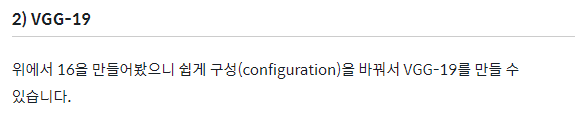

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 준다.

vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

In [ ]:
# 2-6. Ablation Study 실습 (4) VGG-16 vs VGG-19

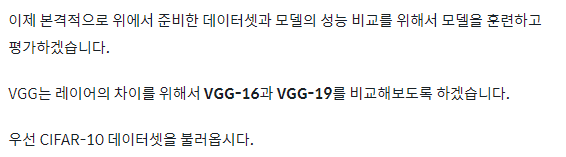

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

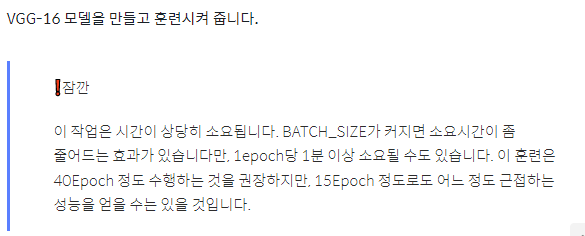

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,


)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 31s 83ms/step - loss: 2.1944 - accuracy: 0.1886 - val_loss: 2.0687 - val_accuracy: 0.2423
Epoch 2/15
195/195 [==============================] - 16s 80ms/step - loss: 1.9962 - accuracy: 0.2785 - val_loss: 1.9154 - val_accuracy: 0.3311
Epoch 3/15
195/195 [==============================] - 15s 78ms/step - loss: 1.8571 - accuracy: 0.3322 - val_loss: 1.7675 - val_accuracy: 0.3751
Epoch 4/15
195/195 [==============================] - 15s 79ms/step - loss: 1.7471 - accuracy: 0.3738 - val_loss: 1.6887 - val_accuracy: 0.3988
Epoch 5/15
195/195 [==============================] - 15s 78ms/step - loss: 1.6607 - accuracy: 0.4044 - val_loss: 1.6726 - val_accuracy: 0.3913
Epoch 6/15
195/195 [==============================] - 15s 78ms/step - loss: 1.5999 - accuracy: 0.4228 - val_loss: 1.5514 - val_accuracy: 0.4373
Epoch 7/15
195/195 [==============================] - 15s 78ms/step - loss: 1.5430 - accuracy: 0.4481 - val_loss: 1.5099 - val_accuracy: 0.4599
Epo

In [ ]:
# verbose = 학습 중 출력되는 문구를 설정한다.
# 0 : 아무것도 출력하지 않는다.
# 1 : 훈련의 진행도를 보여주는 진행막대를 보여준다.
# 2 : 미니 배치바다 손실 정보를 출력한다. 

# 보통 verbose 2는 잘 사용하지 않는다.

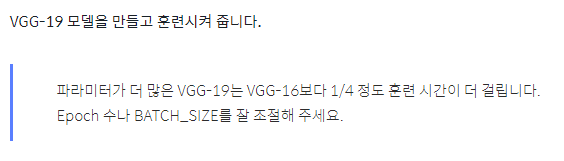

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 22s 91ms/step - loss: 2.2235 - accuracy: 0.1622 - val_loss: 2.1166 - val_accuracy: 0.2102
Epoch 2/15
195/195 [==============================] - 18s 90ms/step - loss: 2.0292 - accuracy: 0.2550 - val_loss: 1.9490 - val_accuracy: 0.2973
Epoch 3/15
195/195 [==============================] - 18s 90ms/step - loss: 1.8878 - accuracy: 0.3160 - val_loss: 1.7938 - val_accuracy: 0.3590
Epoch 4/15
195/195 [==============================] - 18s 90ms/step - loss: 1.7579 - accuracy: 0.3640 - val_loss: 1.6818 - val_accuracy: 0.3775
Epoch 5/15
195/195 [==============================] - 18s 90ms/step - loss: 1.6669 - accuracy: 0.3946 - val_loss: 1.7028 - val_accuracy: 0.3899
Epoch 6/15
195/195 [==============================] - 18s 90ms/step - loss: 1.6042 - accuracy: 0.4194 - val_loss: 1.5469 - val_accuracy: 0.4363
Epoch 7/15
195/195 [==============================] - 18s 91ms/step - loss: 1.5514 - accuracy: 0.4404 - val_loss: 1.5070 - val_accuracy: 0.4609
Epo

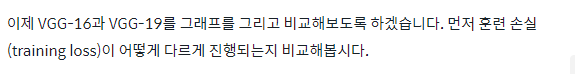

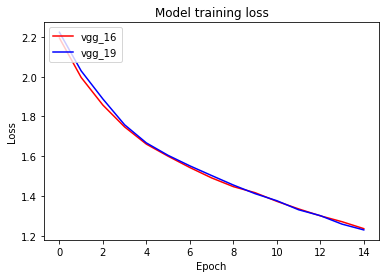

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

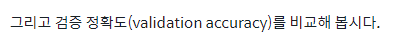

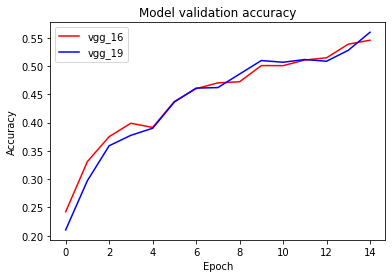

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

결과를 보면 16이나 19나 큰 차이가 없다.

In [ ]:
# 2-7. 프로젝트: ResNet Ablation Study

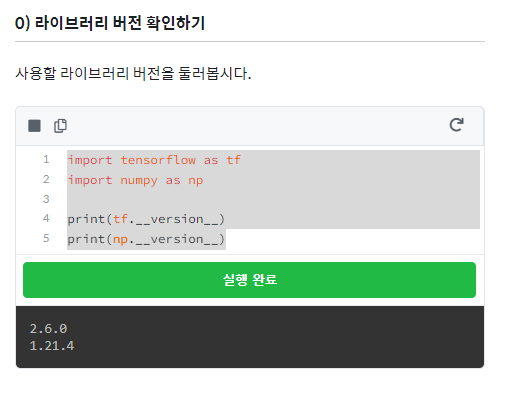

In [ ]:
import tensorflow as tf
import numpy as np
import keras 
# from tensorflow import keras
import urllib3
urllib3.disable_warnings()

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [ ]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [ ]:
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False, activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
resnet_34 = build_resnet(is_50 = False)
resnet_50 = build_resnet(is_50 = True)
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

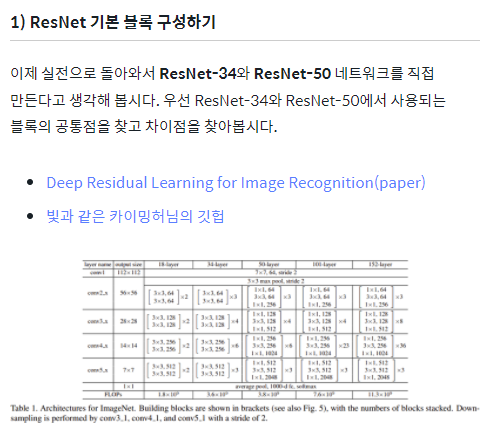

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Farxiv.org%2Fpdf%2F1512.03385.pdf&clen=819383&chunk=true

https://github.com/KaimingHe/deep-residual-networks

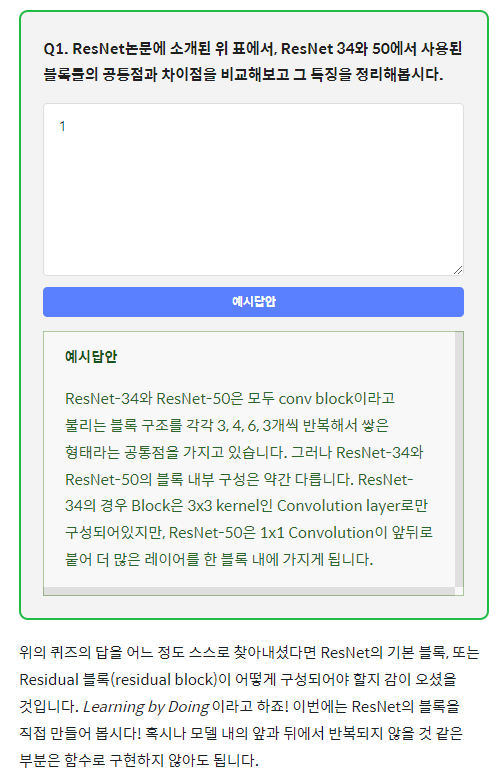

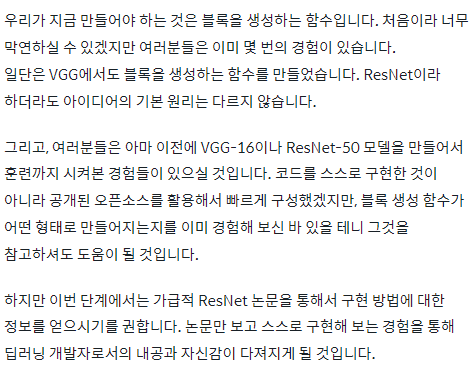

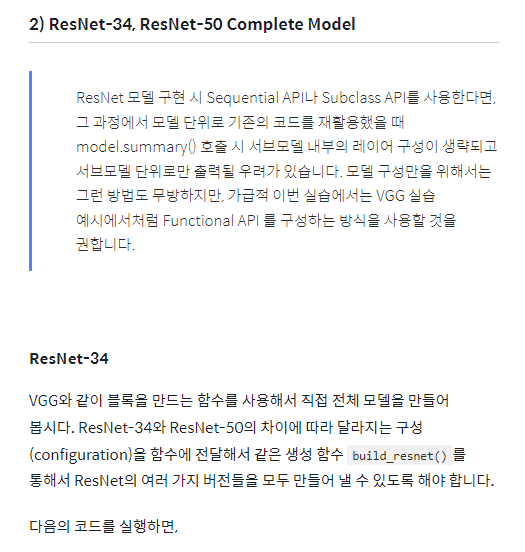

In [ ]:
resnet_34 = build_resnet(input_shape=(224, 224 ,3), is_50=False)
resnet_34.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 112, 112, 64  832         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_238 (Batch  (None, 112, 112, 64  256        ['conv2d_56[0][0]']              
 Normalization)                 )                                                          

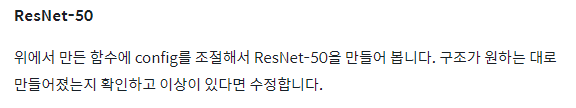

In [ ]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True)
resnet_50.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 112, 112, 64  832         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_255 (Batch  (None, 112, 112, 64  256        ['conv2d_60[0][0]']              
 Normalization)                 )                                                          

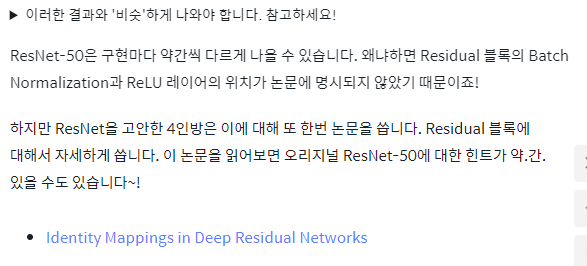

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Farxiv.org%2Fpdf%2F1603.05027.pdf&clen=1166414&chunk=true

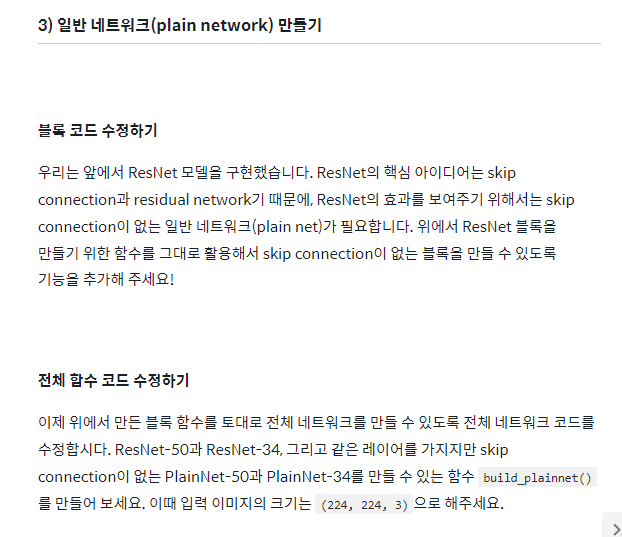

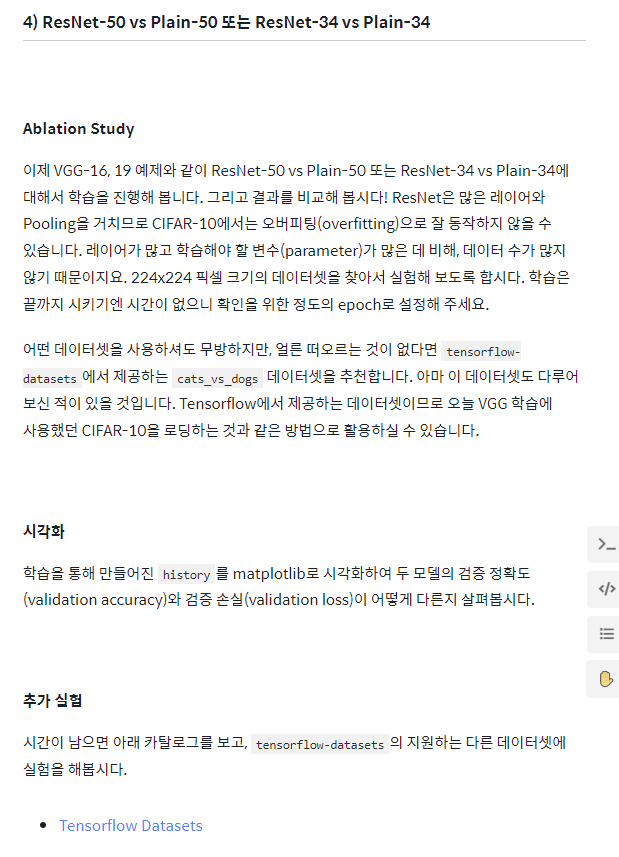

In [ ]:
BATCH_SIZE = 32 # ram 문제로 batch_size 줄임
EPOCH = 15

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


In [ ]:
# import tensorflow_datasets as tfds
# import matplotlib.pyplot as plt
 
# classNames = ['cat', 'dog']
# split = ['train[:70%]', 'train[70%:]']
 
# trainDataset, testDataset = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)
 
# i = 0
# fig, ax = plt.subplots(1, 8)
# for image, label in testDataset.take(8):
#     ax[i].axis('off')
#     ax[i].set_title(classNames[label])
#     ax[i].imshow(image)
#     i += 1
 
# plt.show()

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(16283, shape=(), dtype=int64)
tf.Tensor(6979, shape=(), dtype=int64)


In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

2

In [ ]:
ds_info.features["label"].names

['cat', 'dog']

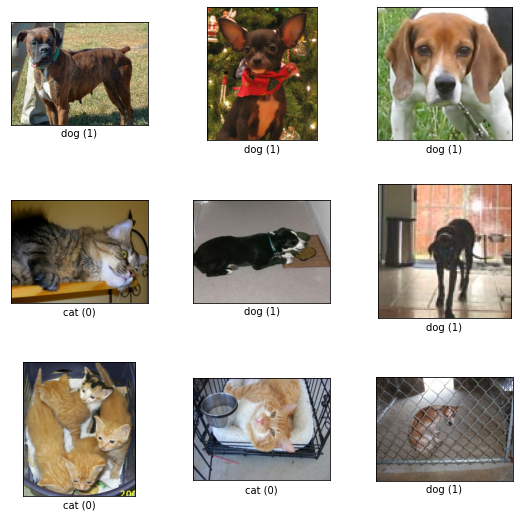

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

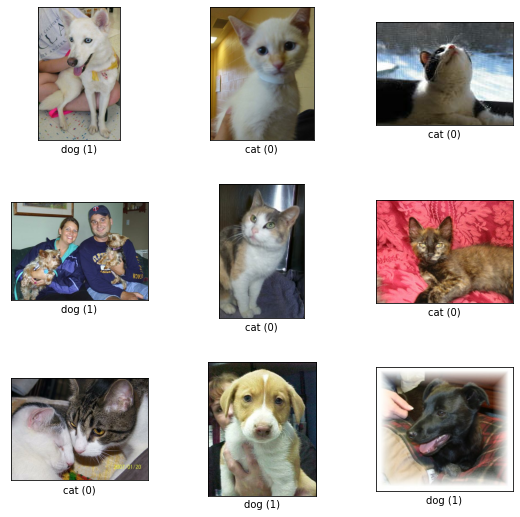

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

In [ ]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False,
                         activation='sigmoid')

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=False,
)

Epoch 1/15
508/508 [==============================] - 72s 121ms/step - loss: 1.3509 - accuracy: 0.5877 - val_loss: 1.6380 - val_accuracy: 0.5245
Epoch 2/15
508/508 [==============================] - 57s 113ms/step - loss: 0.8193 - accuracy: 0.6469 - val_loss: 0.9555 - val_accuracy: 0.6001
Epoch 3/15
508/508 [==============================] - 57s 113ms/step - loss: 0.6175 - accuracy: 0.6947 - val_loss: 0.5926 - val_accuracy: 0.7100
Epoch 4/15
508/508 [==============================] - 57s 113ms/step - loss: 0.5356 - accuracy: 0.7397 - val_loss: 0.6564 - val_accuracy: 0.6908
Epoch 5/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4913 - accuracy: 0.7640 - val_loss: 0.6718 - val_accuracy: 0.6865
Epoch 6/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4484 - accuracy: 0.7874 - val_loss: 0.5714 - val_accuracy: 0.7474
Epoch 7/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4066 - accuracy: 0.8155 - val_loss: 0.5003 - val_ac

In [ ]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
508/508 [==============================] - 68s 113ms/step - loss: 1.4766 - accuracy: 0.5805 - val_loss: 0.8152 - val_accuracy: 0.6473
Epoch 2/15
508/508 [==============================] - 57s 113ms/step - loss: 0.8380 - accuracy: 0.6593 - val_loss: 0.7285 - val_accuracy: 0.6762
Epoch 3/15
508/508 [==============================] - 57s 112ms/step - loss: 0.6230 - accuracy: 0.7023 - val_loss: 4.7881 - val_accuracy: 0.6620
Epoch 4/15
508/508 [==============================] - 57s 113ms/step - loss: 0.5368 - accuracy: 0.7406 - val_loss: 0.5738 - val_accuracy: 0.7153
Epoch 5/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4812 - accuracy: 0.7718 - val_loss: 0.5812 - val_accuracy: 0.7268
Epoch 6/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4351 - accuracy: 0.7961 - val_loss: 0.5736 - val_accuracy: 0.7449
Epoch 7/15
508/508 [==============================] - 57s 112ms/step - loss: 0.3909 - accuracy: 0.8230 - val_loss: 0.4827 - val_ac

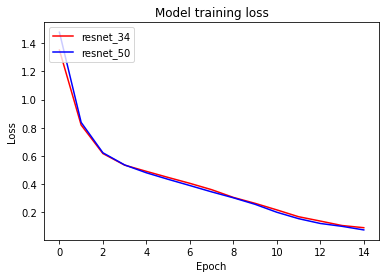

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

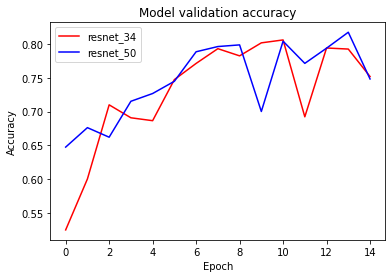

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

In [ ]:
plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)

In [ ]:
plain_resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False)
plain_resnet_34.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 112, 112, 64  832         ['input_21[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_340 (Batch  (None, 112, 112, 64  256        ['conv2d_80[0][0]']              
 Normalization)                 )                                                          

In [ ]:
model_plain_resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False,
                         activation='sigmoid')

In [ ]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_plain_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=False,
)

Epoch 1/15
508/508 [==============================] - 68s 113ms/step - loss: 1.3698 - accuracy: 0.5875 - val_loss: 1.8390 - val_accuracy: 0.5052
Epoch 2/15
508/508 [==============================] - 57s 112ms/step - loss: 0.8018 - accuracy: 0.6517 - val_loss: 1.1587 - val_accuracy: 0.5470
Epoch 3/15
508/508 [==============================] - 57s 113ms/step - loss: 0.6111 - accuracy: 0.6985 - val_loss: 0.7160 - val_accuracy: 0.6499
Epoch 4/15
508/508 [==============================] - 57s 112ms/step - loss: 0.5412 - accuracy: 0.7320 - val_loss: 0.5362 - val_accuracy: 0.7342
Epoch 5/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4871 - accuracy: 0.7621 - val_loss: 0.5435 - val_accuracy: 0.7350
Epoch 6/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4434 - accuracy: 0.7934 - val_loss: 0.5068 - val_accuracy: 0.7593
Epoch 7/15
508/508 [==============================] - 57s 113ms/step - loss: 0.3954 - accuracy: 0.8208 - val_loss: 0.4835 - val_ac

In [ ]:
plain_resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True)
plain_resnet_50.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_88 (Conv2D)             (None, 112, 112, 64  832         ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_374 (Batch  (None, 112, 112, 64  256        ['conv2d_88[0][0]']              
 Normalization)                 )                                                          

In [ ]:
model_plain_resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [ ]:
plain_resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_plain_50 = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=False,
)

Epoch 1/15
508/508 [==============================] - 68s 114ms/step - loss: 1.2803 - accuracy: 0.5893 - val_loss: 0.7448 - val_accuracy: 0.6433
Epoch 2/15
508/508 [==============================] - 57s 113ms/step - loss: 0.7782 - accuracy: 0.6511 - val_loss: 1.0167 - val_accuracy: 0.5767
Epoch 3/15
508/508 [==============================] - 57s 113ms/step - loss: 0.5975 - accuracy: 0.7022 - val_loss: 0.5814 - val_accuracy: 0.7117
Epoch 4/15
508/508 [==============================] - 57s 113ms/step - loss: 0.5284 - accuracy: 0.7400 - val_loss: 0.5165 - val_accuracy: 0.7408
Epoch 5/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4735 - accuracy: 0.7777 - val_loss: 0.5701 - val_accuracy: 0.7488
Epoch 6/15
508/508 [==============================] - 57s 113ms/step - loss: 0.4371 - accuracy: 0.7988 - val_loss: 0.7463 - val_accuracy: 0.7386
Epoch 7/15
508/508 [==============================] - 57s 113ms/step - loss: 0.3903 - accuracy: 0.8219 - val_loss: 0.6381 - val_ac

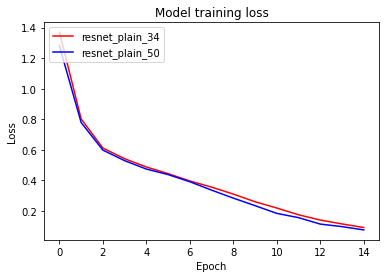

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_plain_34.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_plain_34', 'resnet_plain_50'], loc='upper left')
plt.show()

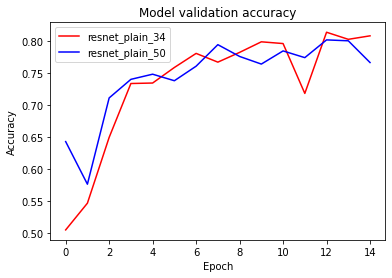

In [ ]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_plain_34', 'resnet_plain_50'], loc='upper left')
plt.show()

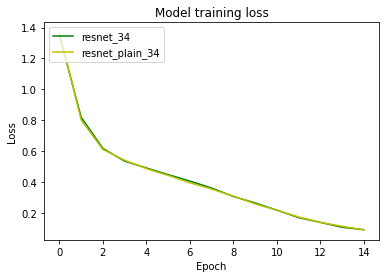

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'g')
plt.plot(history_plain_34.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_plain_34'], loc='upper left')
plt.show()

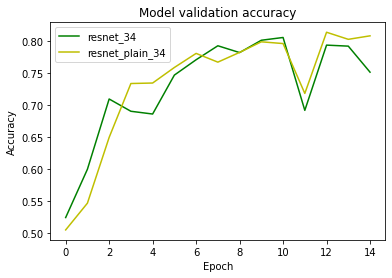

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_plain_34'], loc='upper left')
plt.show()

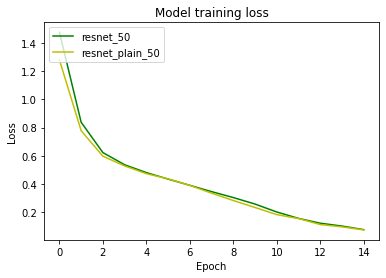

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_50.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_plain_50'], loc='upper left')
plt.show()

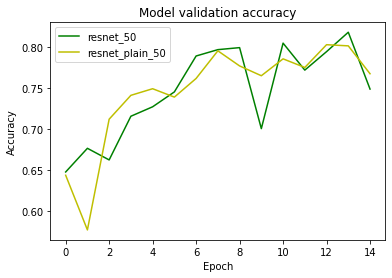

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_plain_50'], loc='upper left')
plt.show()

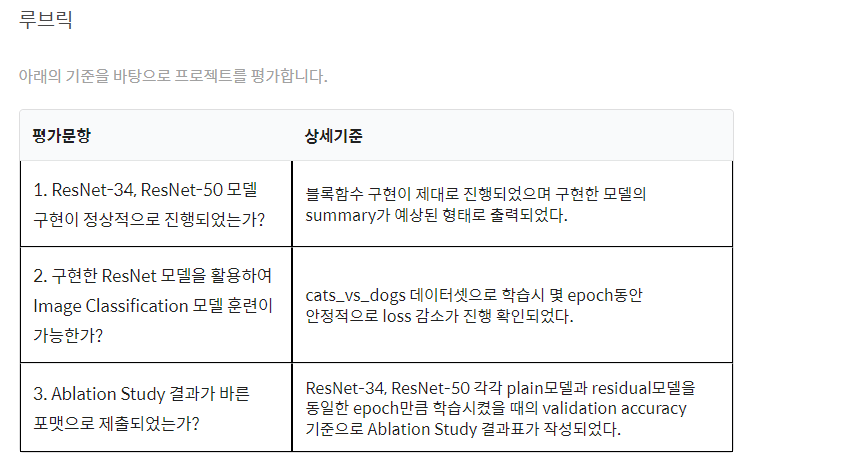

우선은 3가지의 루브릭 평가를 만족시켰지만, plain 모델에 비해서 residual의 accuracy가 향상 되어 있음은 모르겠다. 모델계층은 18, 34, 50, 101, 152계층까지 있는데, 계층을 더 깊게 했으면 결과가 조금이라도 달라지지 않았을까? 생각한다.
유료결제 모델로 코랩 프로로 ram 용량까지 늘렸으나 BATCH_SIZE를 64이상 해버리면 계속 커널 dead현상이 발생하여 시간이 다소 좀 걸리더라도 32로 진행을 하였다.

논문을 보고 직접 구현을 하다가 인터넷에서 검색한 source힘을 빌렸는데, 논문을 보고 온전하게 구현하는 연습이 필요할 것 같다.